### Imports

In [1]:
import os
import json
import sys
import pandas as pd
import random
import operator
import numpy as np
import numpy.random
import netCDF4 as nc
import xarray as xr
import re
import pickle as pkl
import torch
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from torch.autograd import Variable
from math import radians, cos, sin, asin, sqrt
from torch.utils.data import Dataset
from datetime import datetime, timedelta
from time import time, strftime, gmtime
from scipy.stats import binned_statistic

sys.path.append('/home/ninow/master_thesis/code/project/')
from utils.data import DataUtils
from utils import ModelUtils
from model import Baseline

### Define Helper Methods

In [2]:
def load_checkpoint(path, model, optimizer):
    file_path = path + '/model_best.pth.tar'
    if os.path.isfile(file_path):
        print("Loading checkpoint from: %s" % file_path)
        checkpoint = torch.load(file_path)
        epoch = checkpoint['epoch'] + 1
        best_epoch_test_rmse = checkpoint['best_epoch_test_rmse']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("Loaded checkpoint with best test rmse %s (epoch %s)" % (best_epoch_test_rmse, checkpoint['epoch']))
    else:
        raise Exception("No checkpoint found at %s" % file_path)
    return model, optimizer, epoch, best_epoch_test_rmse

def load_trained_network(config):
    
    # assign all program arguments to local variables
    with open(config['model']['path']) as handle:
        ModelDict = json.loads(handle.read())

    # initialize network, optimizer and loss function
    net = Baseline.model_factory(model_dict=ModelDict, params=len(config['input_parameters']),
                                 time_invariant_params=len(config['grid_time_invariant_parameters']),
                                 grid=config['grid_size'], prediction_times=config['prediction_times'])

    # get optimizer config
    optimizer_config = config['optimizer']

    # if not explicitly specified, don't use regularization
    if 'weight_decay' not in optimizer_config: optimizer_config['weight_decay'] = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=optimizer_config['learning_rate'],
                                momentum=optimizer_config['momentum'], weight_decay=optimizer_config['weight_decay'])


    net, optimizer, *_ = load_checkpoint(config['trained_model_output_path'] + '/stored_models/run_0', model=net,
                                                    optimizer=optimizer)

    if torch.cuda.is_available():
        net.cuda()

    # we do not train, but only output the evaluation of the network on train and test data
    net.eval()
    
    return net

In [3]:
def network_output_wrapper(net, X):
    grid_data = getVariable(torch.Tensor(X[:,:22])).float()
    if X.shape[1] >= 30:
        station_time_inv_input = getVariable(torch.Tensor(X[:,22:25])).float()
    else:
        station_time_inv_input = None
    time_data = getVariable(torch.Tensor(X[:,-5:])).float()
    network_output = net(grid_data, time_data, station_time_inv_input).data.cpu().numpy()
    
    grid_data.data.cpu()
    station_time_inv_input.data.cpu()
    time_data.data.cpu()
    
    return network_output

# wrapper for pytorch network output
f = lambda X: network_output_wrapper(net=net, X=X)

def getVariable(tensor):
    if torch.cuda.is_available():
        input = Variable(tensor.cuda())
    else:
        input = Variable(tensor)
    return input.float()

In [4]:
# load station positions to plot them on map
station_data = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_positions = station_data.station_position.sel(positinal_attribute = ['rlat', 'rlon','height_raw'])
stations = station_data.station
station_names = station_data.station_name

# mapping of station id to station index in array represention
station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx

# Uncertainty estimation test data

In [135]:
# set dropout that should be used
dropout = '0_1' #'0_1', '0_25', '0_5'

### Load network ready data

In [136]:
with open('/mnt/ds3lab-scratch/ninow/preprocessed_data/network_ready_data/test_data','rb') as handle:
    network_ready_data_temperature_prediction = pkl.load(handle)

### Load trained network

In [137]:
config_temperature_prediction = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/shap/config.pkl', 'rb'))
config_temperature_prediction['experiment_path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/temperature_prediction/dropout_%s' % dropout
model = config_temperature_prediction['model']
model['path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/temperature_prediction/dropout_%s/models/FC_L3_1024_256_64_TD_GTI_STI.txt' % dropout
config_temperature_prediction['model'] = model
config_temperature_prediction['trained_model_output_path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/temperature_prediction/dropout_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24' % dropout

In [138]:
net_temperature_prediction = load_trained_network(config_temperature_prediction)

{'time_data': True, 'type': 'FC', 'n_fc1': 1024, 'layers': 3, 'name': 'FC_L3_1024_256_64_TD_GTI_STI', 'fc_layers': 3, 'dropout_prop': 0.1, 'n_fc3': 64, 'grid_time_invariant': True, 'n_fc2': 256, 'station_time_invariant': True}
Model uses dropout probability: 0.1
Loading checkpoint from: /mnt/ds3lab-scratch/ninow/final_results/variational_dropout/temperature_prediction/dropout_0_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/stored_models/run_0/model_best.pth.tar
Loaded checkpoint with best test rmse 1.3230336509007303 (epoch 29)


### Run model 100 times with dropout

In [139]:
n_eval = 100
data_temperature_prediction = np.array(network_ready_data_temperature_prediction.as_matrix()[:,2:-2], dtype=np.float64)
ensemble_result_temperature_prediction = np.zeros((n_eval, network_ready_data_temperature_prediction.shape[0]))
for run in range(n_eval):
    net_temperature_prediction.train(True)
    ensemble_result_temperature_prediction[run] = network_output_wrapper(net_temperature_prediction, data_temperature_prediction)[:,0]

### Calculate mean prediction and variance over the 100 runs

In [140]:
mean_prediction_temperature_prediction, var_prediction_temperature_prediction = np.mean(ensemble_result_temperature_prediction, axis=0),np.var(ensemble_result_temperature_prediction, axis=0)

In [141]:
label_temperature_prediction = np.array(network_ready_data_temperature_prediction.as_matrix()[:,-2], dtype=np.float64)
model_error_temperature_prediction = mean_prediction_temperature_prediction - label_temperature_prediction
cosmo_error_temperature_prediction = np.array(network_ready_data_temperature_prediction.as_matrix()[:,-1], dtype=np.float64) - label_temperature_prediction
correction_prediction_temperature_prediction = mean_prediction_temperature_prediction - np.array(network_ready_data_temperature_prediction.as_matrix()[:,-2], dtype=np.float64)
temperature_prediction_temperature_prediction = mean_prediction_temperature_prediction

# Uncertainty Estimation on Test Data with Error Prediction

### Load network ready data

In [142]:
with open('/mnt/ds3lab-scratch/ninow/preprocessed_data/network_ready_data/test_data','rb') as handle:
    network_ready_data_error_prediction = pkl.load(handle)
with open('/mnt/ds3lab-scratch/ninow/preprocessed_data/network_ready_data/train_data','rb') as handle:
    network_ready_data_error_prediction_train = pkl.load(handle)

In [143]:
data_error_prediction = np.array(network_ready_data_error_prediction.as_matrix()[:,2:-2], dtype=np.float64)
error_label_error_prediction = (network_ready_data_error_prediction.as_matrix()[:,-1] - network_ready_data_error_prediction.as_matrix()[:,-2])

### Load trained network

In [144]:
config_error_prediction = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/shap/config.pkl', 'rb'))
config_error_prediction['experiment_path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/error_prediction/dropout_%s' % dropout
model = config_error_prediction['model']
model['path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/error_prediction/dropout_%s/models/FC_L3_1024_256_64_TD_GTI_STI.txt' % dropout
config_error_prediction['model'] = model
config_error_prediction['trained_model_output_path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/error_prediction/dropout_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24' % dropout

In [145]:
net_error_prediction = load_trained_network(config_error_prediction)

{'time_data': True, 'type': 'FC', 'n_fc1': 1024, 'layers': 3, 'name': 'FC_L3_1024_256_64_TD_GTI_STI', 'fc_layers': 3, 'dropout_prop': 0.1, 'n_fc3': 64, 'grid_time_invariant': True, 'n_fc2': 256, 'station_time_invariant': True}
Model uses dropout probability: 0.1
Loading checkpoint from: /mnt/ds3lab-scratch/ninow/final_results/variational_dropout/error_prediction/dropout_0_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/stored_models/run_0/model_best.pth.tar
Loaded checkpoint with best test rmse 1.282783845782912 (epoch 28)


### Run model 100 times with dropout

In [146]:
n_eval = 100
ensemble_result_error_prediction = np.zeros((n_eval, data_error_prediction.shape[0]))
for run in range(n_eval):
    net_error_prediction.train(True)
    ensemble_result_error_prediction[run] = network_output_wrapper(net_error_prediction, data_error_prediction)[:,0]

### Calculate mean prediction and variance over the 100 runs

In [147]:
mean_prediction_error_prediction, var_prediction_error_prediction = np.mean(ensemble_result_error_prediction, axis=0), np.var(ensemble_result_error_prediction, axis=0)

In [148]:
temperature_label_error_prediction = network_ready_data_error_prediction.as_matrix()[:,-2]
temperature_prediction_error_prediction = network_ready_data_error_prediction.as_matrix()[:,-1] - mean_prediction_error_prediction
model_temperature_error_error_prediction = temperature_prediction_error_prediction - network_ready_data_error_prediction.as_matrix()[:,-2]
model_error_error_error_predition = mean_prediction_error_prediction - error_label_error_prediction
error_label_error_prediction = error_label_error_prediction
correction_prediction_error_prediction = mean_prediction_error_prediction

## Plot Uncertainty estimation for direct temperature predictiong and error predicting networks

### Calculate RMSE of mean prediction

In [149]:
mean_estimate_error_temperature_prediction = np.sqrt(np.mean(np.square(model_error_temperature_prediction)))
mean_estimate_error_error_prediction = np.sqrt(np.mean(np.square(model_temperature_error_error_prediction)))
mean_estimate_error_temperature_prediction, mean_estimate_error_error_prediction

(1.3244232101700901, 1.283026563685134)

### Plot Uncertainty against error, temp. prediction, error correction.

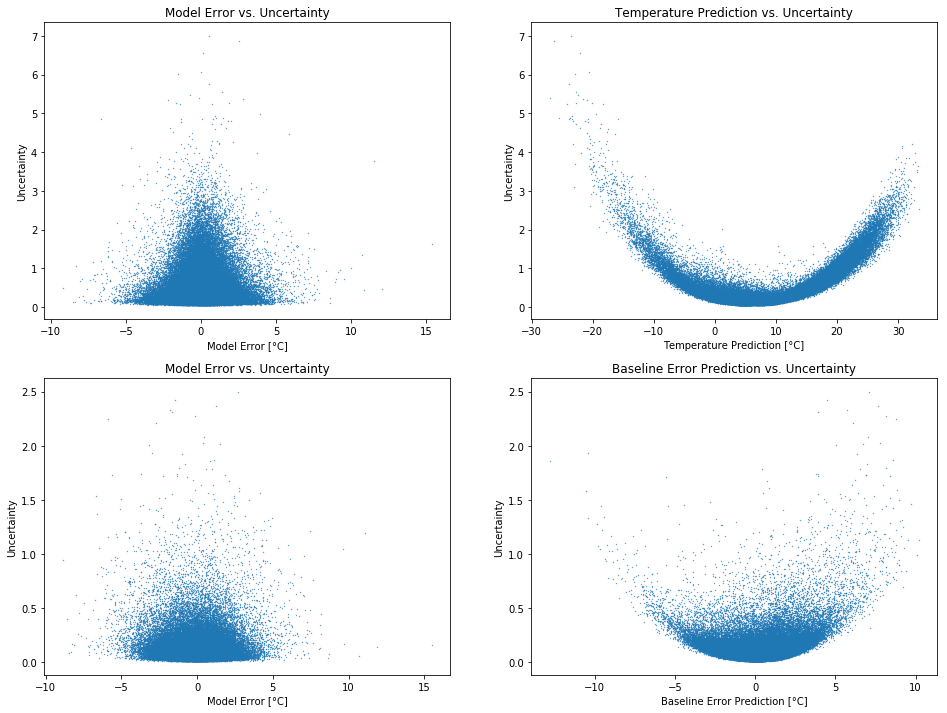

In [152]:
fig, axis = plt.subplots(2,2, figsize=(16,12))

axis[0,0].scatter(model_error_temperature_prediction, var_prediction_temperature_prediction, s=0.1)
axis[0,0].set_xlabel('Model Error [°C]')
axis[0,0].set_ylabel('Uncertainty')
axis[0,0].set_title('Model Error vs. Uncertainty')

axis[0,1].scatter(temperature_prediction_temperature_prediction, var_prediction_temperature_prediction, s=0.1)
axis[0,1].set_xlabel('Temperature Prediction [°C]')
axis[0,1].set_ylabel('Uncertainty')
axis[0,1].set_title('Temperature Prediction vs. Uncertainty')

axis[1,0].scatter(model_temperature_error_error_prediction, var_prediction_error_prediction, s=0.1)
axis[1,0].set_xlabel('Model Error [°C]')
axis[1,0].set_ylabel('Uncertainty')
axis[1,0].set_title('Model Error vs. Uncertainty')

axis[1,1].scatter(correction_prediction_error_prediction, var_prediction_error_prediction, s=0.1)
axis[1,1].set_xlabel('Baseline Error Prediction [°C]')
axis[1,1].set_ylabel('Uncertainty')
axis[1,1].set_title('Baseline Error Prediction vs. Uncertainty')

plt.show()

<Figure size 432x288 with 0 Axes>

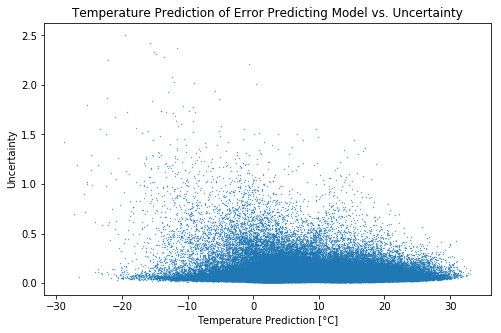

In [156]:
fig, axis = plt.subplots(figsize=(8,5))
axis.scatter(temperature_prediction_error_prediction, var_prediction_error_prediction, s=0.1)
axis.set_xlabel('Temperature Prediction [°C]')
axis.set_ylabel('Uncertainty')
axis.set_title('Temperature Prediction of Error Predicting Model vs. Uncertainty')
plt.show()

### Plot ditribution of temperature/correction against mean uncertainty

In [131]:
mean_uncertainty_by_temp, temp_edges, _ = binned_statistic(temperature_prediction_temperature_prediction.squeeze(),
                                            var_prediction_temperature_prediction.squeeze(),
                                            'mean',
                                            100,
                                            (np.min(temperature_prediction_temperature_prediction), np.max(temperature_prediction_temperature_prediction)))

mean_uncertainty_by_correction, correction_edges, _ = binned_statistic(correction_prediction_error_prediction.squeeze(),
                                            var_prediction_error_prediction.squeeze(),
                                            'mean',
                                            100,
                                            (np.min(correction_prediction_error_prediction), np.max(correction_prediction_error_prediction)))

In [132]:
Y_temp_train = network_ready_data_error_prediction_train.as_matrix()[:,-2].astype(float)
Y_correction_train = network_ready_data_error_prediction_train.as_matrix()[:,-1].astype(float) - network_ready_data_error_prediction_train.as_matrix()[:,-2].astype(float)

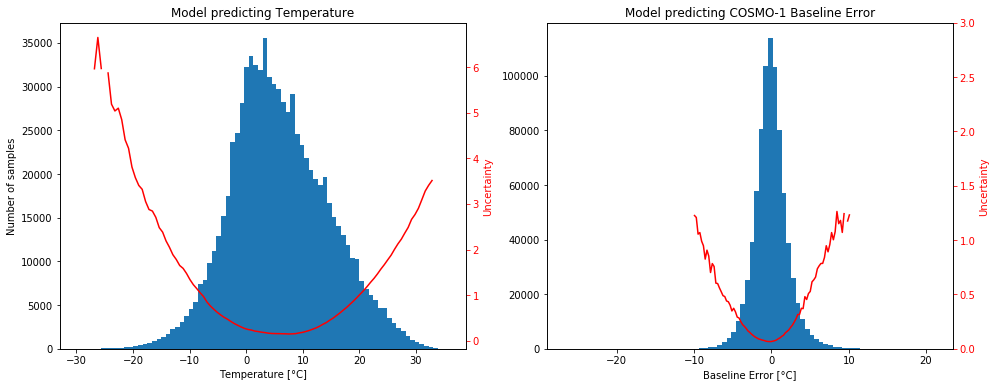

In [134]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].hist(Y_temp_train, bins=80)
ax02 = ax[0].twinx()
ax02.plot(temp_edges[:-1], mean_uncertainty_by_temp, color='red')
ax[0].set_xlabel('Temperature [°C]')
ax[0].set_ylabel('Number of samples')
ax02.set_ylabel('Uncertainty', color='red')
ax02.tick_params('y', colors='red')
ax[0].set_title('Model predicting Temperature')

ax[1].hist(Y_correction_train, bins=80)
ax12 = ax[1].twinx()
ax12.plot(correction_edges[:-1], mean_uncertainty_by_correction, color='red')
ax[1].set_xlabel('Baseline Error [°C]')
ax12.set_ylabel('Uncertainty', color='red')
ax12.tick_params('y', colors='red')
ax12.set_ylim(0,3)
ax[1].set_title('Model predicting COSMO-1 Baseline Error')

plt.show()

# Backup (not used)

In [ ]:
fig, axis = plt.subplots(3,3, figsize=(16,16))

axis[0,0].scatter(model_squared_error_per_prediction, std_prediction)
axis[0,0].set_xlabel('Model Error [°C]')
axis[0,0].set_ylabel('Uncertainty')
axis[0,0].set_title('Model Error vs. Uncertainty')

axis[1,0].scatter(np.absolute(model_squared_error_per_prediction), std_prediction)
axis[1,0].set_xlabel('Absolute Model Error [°C]')
axis[1,0].set_ylabel('Uncertainty')
axis[1,0].set_title('Abs. Model Error vs. Uncertainty')

axis[2,0].scatter(correction_per_prediction, std_prediction)
axis[2,0].set_xlabel('Correction [°C]')
axis[2,0].set_ylabel('Uncertainty')
axis[2,0].set_title('Correction vs. Uncertainty')

axis[0,1].scatter(label, std_prediction)
axis[0,1].set_xlabel('Label [°C]')
axis[0,1].set_ylabel('Uncertainty')
axis[0,1].set_title('Label Value vs. Uncertainty')

axis[1,1].scatter(np.absolute(label), std_prediction)
axis[1,1].set_xlabel('Absolute Label [°C]')
axis[1,1].set_ylabel('Uncertainty')
axis[1,1].set_title('Abs. Label Value vs. Uncertainty')

axis[2,1].scatter(prediction, std_prediction)
axis[2,1].set_xlabel('Prediction [°C]')
axis[2,1].set_ylabel('Uncertainty')
axis[2,1].set_title('Prediction vs. Uncertainty')

axis[0,2].scatter(np.absolute(prediction), std_prediction)
axis[0,2].set_xlabel('Absolute Prediction [°C]')
axis[0,2].set_ylabel('Uncertainty')
axis[0,2].set_title('Abs. Prediction vs. Uncertainty')

axis[1,2].scatter(prediction, model_squared_error_per_prediction)
axis[1,2].set_xlabel('Prediction [°C]')
axis[1,2].set_ylabel('Model Error [°C]')
axis[1,2].set_title('Prediction vs. Model Error')

axis[2,2].scatter(np.absolute(prediction), np.absolute(model_squared_error_per_prediction))
axis[2,2].set_xlabel('Absolute Prediction [°C]')
axis[2,2].set_ylabel('Absolute Model Error [°C]')
axis[2,2].set_title('Abs. Prediction vs. Abs. Model Error')

plt.show()

In [ ]:
n_bins = 100

fig, axis = plt.subplots(3,3, figsize=(16,16))

axis[0,0].hist2d(model_squared_error_per_prediction, std_prediction, bins=n_bins)
axis[0,0].set_xlabel('Model Error [°C]')
axis[0,0].set_ylabel('Uncertainty')
axis[0,0].set_title('Model Error vs. Uncertainty')

axis[1,0].hist2d(np.absolute(model_squared_error_per_prediction), std_prediction, bins=n_bins)
axis[1,0].set_xlabel('Absolute Model Error [°C]')
axis[1,0].set_ylabel('Uncertainty')
axis[1,0].set_title('Abs. Model Error vs. Uncertainty')

axis[2,0].hist2d(correction_per_prediction, std_prediction, bins=n_bins)
axis[2,0].set_xlabel('Correction [°C]')
axis[2,0].set_ylabel('Uncertainty')
axis[2,0].set_title('Correction vs. Uncertainty')

axis[0,1].hist2d(label, std_prediction, bins=n_bins)
axis[0,1].set_xlabel('Label [°C]')
axis[0,1].set_ylabel('Uncertainty')
axis[0,1].set_title('Label Value vs. Uncertainty')

axis[1,1].hist2d(np.absolute(label), std_prediction, bins=n_bins)
axis[1,1].set_xlabel('Absolute Label [°C]')
axis[1,1].set_ylabel('Uncertainty')
axis[1,1].set_title('Abs. Label Value vs. Uncertainty')

axis[2,1].hist2d(prediction, std_prediction, bins=n_bins)
axis[2,1].set_xlabel('Prediction [°C]')
axis[2,1].set_ylabel('Uncertainty')
axis[2,1].set_title('Prediction vs. Uncertainty')

axis[0,2].hist2d(np.absolute(prediction), std_prediction, bins=n_bins)
axis[0,2].set_xlabel('Absolute Prediction [°C]')
axis[0,2].set_ylabel('Uncertainty')
axis[0,2].set_title('Abs. Prediction vs. Uncertainty')

axis[1,2].hist2d(prediction, model_squared_error_per_prediction, bins=n_bins)
axis[1,2].set_xlabel('Prediction [°C]')
axis[1,2].set_ylabel('Model Error [°C]')
axis[1,2].set_title('Prediction vs. Model Error')

axis[2,2].hist2d(np.absolute(prediction), np.absolute(model_squared_error_per_prediction), bins=n_bins)
axis[2,2].set_xlabel('Absolute Prediction [°C]')
axis[2,2].set_ylabel('Absolute Model Error [°C]')
axis[2,2].set_title('Abs. Prediction vs. Abs. Model Error')

plt.show()

In [ ]:
### Plot uncertainty correlation with features

In [ ]:
feature_names = network_ready_data.columns[2:-2]

fig, axis = plt.subplots(10,3, figsize=(16,56))

for idx, feature_name in enumerate(feature_names):
    x_idx = idx%10
    y_idx = int(idx/10)
    axis[x_idx,y_idx].scatter(data[:,idx], std_prediction)
    axis[x_idx,y_idx].set_xlabel('Feature Value')
    axis[x_idx,y_idx].set_ylabel('Uncertainty')
    axis[x_idx,y_idx].set_title('%s vs. Uncertainty' % feature_names[idx])

plt.show()

In [ ]:
feature_names = network_ready_data.columns[2:-2]
n_bins = 100

fig, axis = plt.subplots(10,3, figsize=(16,56))

for idx, feature_name in enumerate(feature_names):
    x_idx = idx%10
    y_idx = int(idx/10)
    axis[x_idx,y_idx].hist2d(data[:,idx], std_prediction, bins=n_bins)
    axis[x_idx,y_idx].set_xlabel('Feature Value')
    axis[x_idx,y_idx].set_ylabel('Uncertainty')
    axis[x_idx,y_idx].set_title('%s vs. Uncertainty' % feature_names[idx])

plt.show()

In [ ]:
### Uncertainty estimation on train vs. test data

In [ ]:
### Load network ready train and test data

In [ ]:
with open('/mnt/ds3lab-scratch/ninow/preprocessed_data/network_ready_data/test_data','rb') as handle:
    network_ready_test_data = pkl.load(handle)
with open('/mnt/ds3lab-scratch/ninow/preprocessed_data/network_ready_data/train_data','rb') as handle:
    network_ready_train_data = pkl.load(handle)

In [ ]:
### Run model 100 times with dropout

In [ ]:
n_eval = 100
batch_size = 10000
data_test = np.array(network_ready_test_data.as_matrix()[:,2:-2], dtype=np.float64)
ensemble_result_test = np.zeros((n_eval, network_ready_test_data.shape[0]))
for run in range(n_eval):
    net.train(True)
    for batch_idx in np.arange(data_test.shape[0])[::batch_size]:
        batched_data = data_test[batch_idx:batch_idx+batch_size]
        ensemble_result_test[run, batch_idx:batch_idx+batch_size] = network_output_wrapper(net, batched_data)[:,0]

In [ ]:
n_eval = 100
batch_size = 10000
data_train = np.array(network_ready_train_data.as_matrix()[:,2:-2], dtype=np.float64)
ensemble_result_train = np.zeros((n_eval, network_ready_train_data.shape[0]))
for run in range(n_eval):
    net.train(True)
    for batch_idx in np.arange(data_train.shape[0])[::batch_size]:
        batched_data = data_train[batch_idx:batch_idx+batch_size]
        ensemble_result_train[run, batch_idx:batch_idx+batch_size] = network_output_wrapper(net, batched_data)[:,0]

In [ ]:
mean_prediction_train, std_prediction_train = np.mean(ensemble_result_train, axis=0), np.std(ensemble_result_train, axis=0)
mean_prediction_test, std_prediction_test = np.mean(ensemble_result_test, axis=0), np.std(ensemble_result_test, axis=0)

In [ ]:
train_rmse = np.sqrt(np.nanmean(np.square(mean_prediction_train - np.array(network_ready_train_data.as_matrix()[:,-2], dtype=np.float64))))
test_rmse = np.sqrt(np.nanmean(np.square(mean_prediction_test - np.array(network_ready_test_data.as_matrix()[:,-2], dtype=np.float64))))
train_std = np.mean(std_prediction_train)
test_std = np.mean(std_prediction_test)

In [ ]:
train_rmse, test_rmse, train_std, test_std

In [ ]:
### Plot ditribution of temperature

In [ ]:
mean_prediction_test, std_prediction_test = np.mean(ensemble_result_test, axis=0), np.std(ensemble_result_test, axis=0)

In [ ]:
mean_uncertainty_by_temp_test = binned_statistic(temp_data_train.squeeze(),
                                            std_prediction_test.squeeze(),
                                            'mean',
                                            100,
                                            (0, 1)).statistic

In [ ]:
temp_data_test = network_ready_test_data[['2m-Temperature']].as_matrix()

fig, ax1 = plt.subplots()
ax1.hist(temp_data_test, bins=100)
ax2 = ax1.twinx()
ax2.plot(np.arange(0,1,0.01),mean_uncertainty_by_temp, color='red')
plt.show()

In [ ]:
temp_data_train = network_ready_train_data[['2m-Temperature']].as_matrix()

fig, ax1 = plt.subplots()
ax1.hist(temp_data_train, bins=100)
ax2 = ax1.twinx()
ax2.plot(np.arange(0,1,0.01), mean_uncertainty_by_temp, color='red')
plt.show()

In [ ]:
model_error_test = np.absolute(mean_prediction_test - np.array(network_ready_test_data.as_matrix()[:,-2], dtype=np.float64))

mean_error_by_temp_test = binned_statistic(temp_data_test.squeeze(),
                                            model_error_test.squeeze(),
                                            'mean',
                                            100,
                                            (0, 1)).statistic

In [ ]:
fig, ax1 = plt.subplots()
ax1.hist(temp_data_train, bins=100)
ax2 = ax1.twinx()
ax2.plot(np.arange(0,1,0.01), mean_error_by_temp_test, color='red')
plt.show()

In [ ]:
### Calculate binned variance

In [ ]:
model_error_test = np.absolute(mean_prediction_test - np.array(network_ready_test_data.as_matrix()[:,-2], dtype=np.float64))

std_by_temp_test = binned_statistic(temp_data_test.squeeze(),
                                            model_error_test.squeeze(),
                                            lambda bin_data: np.std(bin_data),
                                            100,
                                            (0, 1)).statistic

In [ ]:
fig, ax1 = plt.subplots()
ax1.hist(temp_data_train, bins=100)
ax2 = ax1.twinx()
ax2.plot(np.arange(0,1,0.01), std_by_temp_test, color='red')
plt.show()